# Preparation

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-29 05:57:33--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.006s  

2023-08-29 05:57:33 (58.4 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-08-29 05:57:33--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

## Import the Data

In [ ]:
# กำหนดชื่อคอลัมน์สำหรับข้อมูล
column_names = ['label', 'message']  # คอลัมน์แรกคือประเภท (ham/spam) คอลัมน์ที่สองคือข้อความ SMS

# อ่านข้อมูลฝึกฝนเข้ามาเป็น DataFrame โดยใช้ tab ("\t") เป็นตัวคั่นข้อมูลและกำหนดชื่อคอลัมน์
train_data = pd.read_csv(train_file_path, sep="\t", names=column_names)
train_data.head()  # แสดง 5 แถวแรกของข้อมูลฝึกฝนเพื่อตรวจสอบ

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
# อ่านข้อมูลทดสอบเข้ามาเป็น DataFrame เช่นเดียวกับข้อมูลฝึกฝน
test_data = pd.read_csv(test_file_path, sep="\t", names=column_names)
test_data.head()  # แสดง 5 แถวแรกของข้อมูลทดสอบเพื่อตรวจสอบ

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
# แสดงข้อมูลเพิ่มเติมเกี่ยวกับชุดข้อมูลฝึกฝน
train_data.info()
# ผลลัพธ์จะแสดงจำนวนแถว ชนิดข้อมูลของแต่ละคอลัมน์ และหน่วยความจำที่ใช้

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1392 non-null   object
 1   message  1392 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


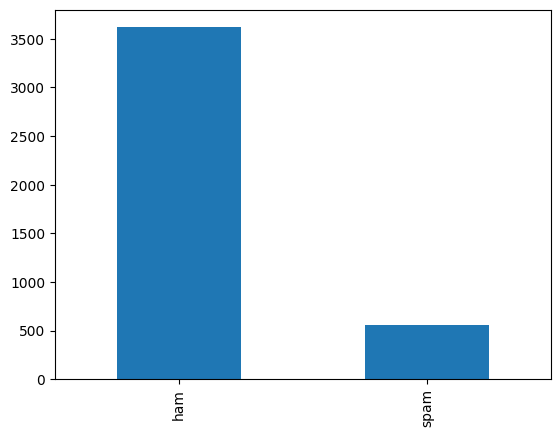

In [ ]:
# แสดงกราฟแท่งเพื่อดูการกระจายของข้อมูล (ham vs spam) ในชุดข้อมูลฝึกฝน
train_data['label'].value_counts().plot.bar()
# จากกราฟจะเห็นว่าข้อมูลไม่สมดุล - มี ham (ข้อความปกติ) มากกว่า spam (ข้อความขยะ) มาก

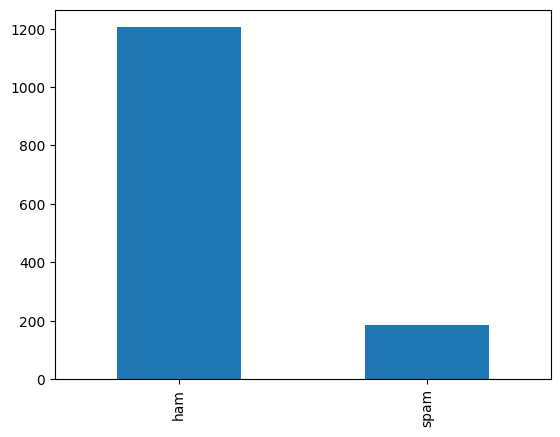

In [ ]:
test_data['label'].value_counts().plot.bar();

## Undersampling

เนื่องจากข้อมูลของเราอยู่ในสถานะไม่สมดุล เราจะแก้ปัญหานี้โดยใช้วิธีการสุ่มตัวอย่างไม่เพียงพอ

In [ ]:
# การแก้ปัญหาข้อมูลไม่สมดุลด้วยวิธี Undersampling

from imblearn.under_sampling import RandomUnderSampler  # นำเข้าไลบรารีสำหรับทำ undersampling
from collections import Counter  # ใช้สำหรับนับจำนวนแต่ละประเภท

# แยกข้อมูลเป็นคุณลักษณะ (X) และฉลาก (y)
X_train = train_data["message"]  # คุณลักษณะคือข้อความ SMS
y_train = train_data["label"]    # ฉลากคือ ham หรือ spam

X_test = test_data["message"]    # คุณลักษณะทดสอบ
y_test = test_data["label"]      # ฉลากทดสอบ

# ทำ undersampling เพื่อแก้ปัญหาความไม่สมดุลของข้อมูลในชุดฝึกฝน
# โดยจะสุ่มลดจำนวนของประเภทที่มีข้อมูลมากเกินไป (ham) ให้เท่ากับประเภทที่มีข้อมูลน้อย (spam)
under_sampler = RandomUnderSampler(random_state=42)  # กำหนด random seed เพื่อให้ผลลัพธ์คงที่
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train.to_frame(), y_train)

X_train_resampled = X_train_resampled.squeeze()  # แปลงกลับเป็น Series จาก DataFrame

# ตรวจสอบการกระจายของประเภทหลังทำ undersampling
print("Class distribution after undersampling (train dataset):", Counter(y_train_resampled))
# ผลลัพธ์จะแสดงว่าตอนนี้มีจำนวน ham และ spam เท่ากัน

Class distribution after undersampling (train dataset): Counter({'ham': 560, 'spam': 560})


In [1]:
# แสดงกราฟการกระจายของข้อมูลหลังทำ undersampling

y_train_resampled.value_counts().plot.bar()
# กราฟจะแสดงให้เห็นว่าข้อมูลมีความสมดุลแล้ว ham และ spam มีจำนวนเท่ากัน

NameError: name 'y_train_resampled' is not defined

## Data Transformation

In [ ]:
# การแปลงข้อมูลข้อความให้เป็นตัวเลขที่โมเดลเข้าใจได้

from keras.preprocessing.text import Tokenizer  # ใช้แปลงข้อความเป็น token
from keras.preprocessing.sequence import pad_sequences  # ใช้ปรับความยาวของ sequence ให้เท่ากัน

# สร้าง tokenizer และฝึกบน X_train_resampled
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resampled)  # เรียนรู้คำศัพท์จากข้อความฝึกฝน

# แปลงข้อความเป็นลำดับของเลขจำนวนเต็ม (sequences)
train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
test_sequences = tokenizer.texts_to_sequences(X_test)

# ปรับความยาวของ sequence ให้เท่ากันทั้งหมด (padding)
max_sequence_length = max(max(len(sequence) for sequence in train_sequences), max(len(sequence) for sequence in test_sequences))
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding="post")

In [ ]:
# แปลงฉลาก (ham/spam) เป็นตัวเลข (0/1)
label_mapping = {label: index for index, label in enumerate(train_data["label"].unique())}  # สร้าง dictionary การแปลง
train_numerical_labels = y_train_resampled.map(label_mapping)  # แปลงฉลากข้อมูลฝึกฝน
test_numerical_labels = y_test.map(label_mapping)  # แปลงฉลากข้อมูลทดสอบ

# Build the Model

In [ ]:
# สร้างโมเดล LSTM แบบสองทิศทาง (Bidirectional)

model = tf.keras.models.Sequential()  # สร้างโมเดลแบบเรียงลำดับ

# เพิ่มเลเยอร์ Embedding เพื่อแปลงตัวเลขที่แทนคำให้เป็นเวกเตอร์มิติสูง
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))

# เพิ่มเลเยอร์ LSTM แบบสองทิศทาง (สามารถเรียนรู้ความสัมพันธ์ของข้อความทั้งจากซ้ายไปขวาและขวาไปซ้าย)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

# เลเยอร์สุดท้ายเป็นเลเยอร์ Dense 1 โหนด กับ activation function แบบ sigmoid (ให้ผลลัพธ์เป็นค่าความน่าจะเป็น 0-1)
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# compile
model.compile(
    loss="binary_crossentropy",  # ฟังก์ชันการสูญเสียสำหรับการจำแนกแบบไบนารี (2 ประเภท)
    optimizer="adam",  # อัลกอริทึมการเรียนรู้
    metrics=["accuracy"]  # ใช้ accuracy เป็นเมตริกในการวัดผล
)

In [ ]:
# แสดงโครงสร้างโมเดล
model.summary()
# ผลลัพธ์จะแสดงรายละเอียดของแต่ละเลเยอร์ จำนวนพารามิเตอร์ และขนาดเอาต์พุต

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 189, 128)          520320    
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 619265 (2.36 MB)
Trainable params: 619265 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## Train the model

model.fit(
    padded_train_sequences,        # ข้อมูล input ที่ใช้ฝึกฝน
    train_numerical_labels,        # ฉลากเป้าหมาย
    validation_data=(padded_test_sequences, test_numerical_labels),  # ข้อมูลสำหรับตรวจสอบความแม่นยำระหว่างฝึกฝน
    epochs=5,                       # จำนวนรอบในการฝึกฝน
    batch_size=32                  # ขนาดแบตช์
)
# ผลลัพธ์จะแสดงค่า loss และ accuracy ทั้งในชุดฝึกฝนและชุดตรวจสอบในแต่ละ epoch

Epoch 1/5
35/35 [==============================] - 18s 367ms/step - loss: 0.5565 - accuracy: 0.7482 - val_loss: 0.3522 - val_accuracy: 0.8499
Epoch 2/5
35/35 [==============================] - 18s 519ms/step - loss: 0.1937 - accuracy: 0.9366 - val_loss: 0.1654 - val_accuracy: 0.9591
Epoch 3/5
35/35 [==============================] - 14s 405ms/step - loss: 0.0664 - accuracy: 0.9821 - val_loss: 0.1123 - val_accuracy: 0.9655
Epoch 4/5
35/35 [==============================] - 10s 275ms/step - loss: 0.0246 - accuracy: 0.9955 - val_loss: 0.0763 - val_accuracy: 0.9799
Epoch 5/5
35/35 [==============================] - 12s 345ms/step - loss: 0.0123 - accuracy: 0.9982 - val_loss: 0.0721 - val_accuracy: 0.9813


## Evaluate the model

In [ ]:
# ประเมินโมเดลกับชุดข้อมูลทดสอบ
loss, accuracy = model.evaluate(padded_test_sequences, test_numerical_labels)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
# ผลลัพธ์จะแสดงค่า loss และ accuracy สุดท้ายบนชุดข้อมูลทดสอบ

44/44 [==============================] - 3s 58ms/step - loss: 0.0721 - accuracy: 0.9813
Test Loss: 0.0721, Test Accuracy: 0.9813


# Submission

In [ ]:
# ฟังก์ชันสำหรับทำนายว่าข้อความเป็น spam หรือ ham
def predict_message(pred_text):
    # ตรวจสอบว่าอินพุตเป็นรายการหรือไม่ ถ้าไม่ใช่ให้แปลงเป็นรายการ
    if not isinstance(pred_text, list):
        pred_text = [pred_text]

    # แปลงข้อความเป็น sequence และทำ padding
    sequences = tokenizer.texts_to_sequences(pred_text)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding="post")

    # ทำนายด้วยโมเดล
    predictions = model.predict(padded_sequences)

    # แปลงค่าความน่าจะเป็นเป็นประเภท (0 หรือ 1)
    predicted_labels = (predictions > 0.5).astype(int)

    # รวมผลลัพธ์ให้อยู่ในรูปแบบ [ค่าความน่าจะเป็น, ประเภท]
    results = [[float(prediction), "spam" if label == 1 else "ham"] for prediction, label in zip(predictions, predicted_labels)]

    # ถ้ามีผลลัพธ์เพียงรายการเดียว ให้ส่งคืนเฉพาะรายการนั้น
    if len(results) == 1:
      result = results[0]
    else:
      result = results

    return result

# ทดสอบฟังก์ชันกับข้อความตัวอย่าง
pred_text = "how are you doing today?"
prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 91ms/step
[0.0053630368784070015, 'ham']


In [ ]:
# ฟังก์ชันทดสอบโมเดลกับข้อความตัวอย่างหลายข้อความ
def test_predictions():
  # รายการข้อความทดสอบ
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  # คำตอบที่ถูกต้องสำหรับแต่ละข้อความ
  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  # ทดสอบทีละข้อความและตรวจสอบว่าโมเดลทำนายถูกต้องหรือไม่
  for msg, ans in zip(test_messages, test_answers):
    print(ans)  # แสดงคำตอบที่ถูกต้อง
    prediction = predict_message(msg)  # ทำนายด้วยโมเดล
    print(prediction)  # แสดงผลการทำนาย
    if prediction[1] != ans:  # ตรวจสอบว่าทำนายถูกต้องหรือไม่
      passed = False

  # แสดงผลรวมการทดสอบ
  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

# เรียกใช้ฟังก์ชันทดสอบ
test_predictions()

ham
1/1 [==============================] - 0s 90ms/step
[0.0053630368784070015, 'ham']
spam
1/1 [==============================] - 0s 106ms/step
[0.6308251619338989, 'spam']
ham
1/1 [==============================] - 0s 96ms/step
[0.002444487763568759, 'ham']
spam
1/1 [==============================] - 0s 87ms/step
[0.9890956282615662, 'spam']
spam
1/1 [==============================] - 0s 95ms/step
[0.9961050152778625, 'spam']
ham
1/1 [==============================] - 0s 87ms/step
[0.0026330924592912197, 'ham']
ham
1/1 [==============================] - 0s 84ms/step
[0.006858247797936201, 'ham']
You passed the challenge. Great job!
